## Sampler

In [8]:
import torch
from skimage.data import chelsea

In [9]:
class Sampler:
    def __init__(self, n_steps=50):
        self.beta = torch.linspace(0.0001, 0.02, n_steps)
        self.beta = self.beta[:, None, None, None]  # expand to calculation on batch dimension

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def q_sample(self, x0, timestep, noise=None):
        noise = torch.randn_like(x0) if noise is None else noise
        cur_alpha = self.alpha_bar[timestep]
        # Sample from $q(x_t|x_0)$
        return cur_alpha ** 0.5 * x0 + (1 - cur_alpha) ** 0.5 * noise

In [10]:
ss = Sampler()

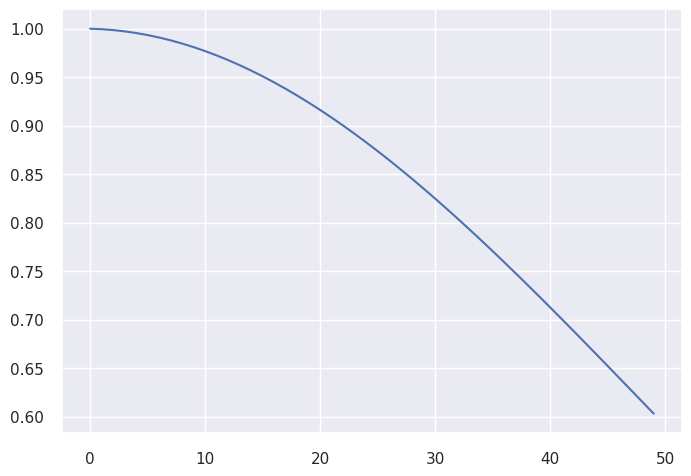

In [11]:
plt.plot(ss.alpha_bar.flatten().numpy())
plt.grid(True)

In [5]:
image = torch.from_numpy(chelsea()[None]).float() / 255
tt = ss.q_sample(image, torch.arange(50)).numpy()
tt.shape

(50, 300, 451, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 4509.5, 1499.5, -0.5)

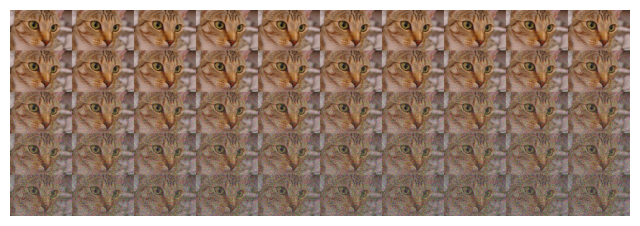

In [6]:
plt.imshow(np.vstack([np.hstack(tt[row * 10: row * 10 + 10]) for row in range(5)]))
plt.axis("off")

In [7]:
tt.max(), tt.min()

(3.0868504, -2.4716287)

## Generate

In [4]:
import unet

eps_model = unet.UNet(n_blocks=2, n_channels=32)

In [8]:
_ = eps_model.eval()
n_samples, image_size = 16, 160
xt = x0 = torch.randn([n_samples, 3, image_size, image_size])

iter = 0
timestep = torch.full([n_samples], ss.n_steps - iter - 1)
with torch.no_grad():
    xt_noise = eps_model(xt, timestep)

cur_alpha_bar = ss.alpha_bar[timestep]
cur_alpha = ss.alpha[timestep]
eps_coef = (1 - cur_alpha) / (1 - cur_alpha_bar) ** .5

eps = torch.randn(xt.shape)
xt = 1 / (cur_alpha_bar ** 0.5) * (xt - eps_coef * xt_noise) + ((1 - cur_alpha) ** 0.5) * eps

In [9]:
xt.shape, xt.min(), xt.max()

(torch.Size([16, 3, 160, 160]), tensor(-6.4545), tensor(6.8501))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2559.5, 159.5, -0.5)

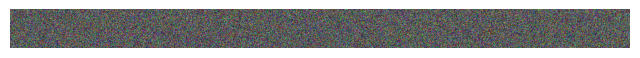

In [11]:
plt.imshow(np.hstack(xt.permute([0, 2, 3, 1]).numpy()))
plt.axis('off')

In [12]:
from tqdm import tqdm

_ = eps_model.eval()
n_samples, image_size = 16, 160
xt = x0 = torch.randn([n_samples, 3, image_size, image_size])

rr = []
for iter in tqdm(range(ss.n_steps)):
    timestep = torch.full([n_samples], ss.n_steps - iter - 1)
    
    with torch.no_grad():
        xt_noise = eps_model(xt, timestep)

    cur_alpha_bar = ss.alpha_bar[timestep]
    cur_alpha = ss.alpha[timestep]
    eps_coef = (1 - cur_alpha) / (1 - cur_alpha_bar) ** .5
    
    eps = torch.randn(xt.shape)
    xt = 1 / (cur_alpha_bar ** 0.5) * (xt - eps_coef * xt_noise) + ((1 - cur_alpha) ** 0.5) * eps
    rr.append(xt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:25<00:00,  4.11s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1599.5, 799.5, -0.5)

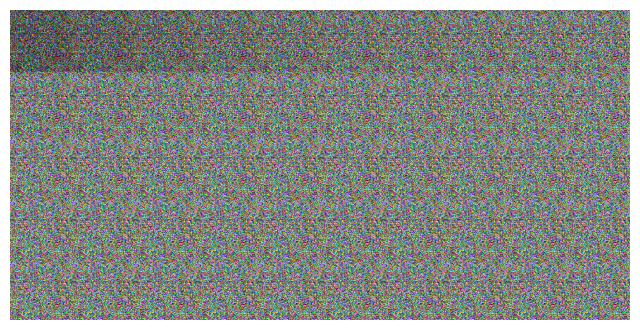

In [16]:
tt = [ii[0].permute([1, 2, 0]).numpy() for ii in rr]
plt.imshow(np.vstack([np.hstack(tt[row * 10: row * 10 + 10]) for row in range(5)]))
plt.axis("off")

## Training

In [1]:
import torch
import torchvision

class DenoiseDiffusion:
    def __init__(self, model, n_steps=100):
        self.model, self.n_steps = model, n_steps
        self.beta = torch.linspace(0.0001, 0.02, n_steps)
        self.beta = self.beta[:, None, None, None]  # expand to calculation on batch dimension

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma2 = self.beta

    def denoise_sample(self, x0, timestep, noise=None):
        noise = torch.randn_like(x0) if noise is None else noise
        cur_alpha = self.alpha_bar[timestep]
        # Sample from $q(x_t|x_0)$
        return cur_alpha ** 0.5 * x0 + (1 - cur_alpha) ** 0.5 * noise

        xt = x0 = torch.randn([n_samples, 3, image_size, image_size])

    def loss(self, x0):
        timestep = torch.randint(0, self.n_steps, (x0.shape[0],))
        noise = torch.randn_like(x0)
        xt = self.denoise_sample(x0, timestep, noise)
        xt_noise = self.model(xt, timestep)
        return torch.functional.F.mse_loss(noise, xt_noise)

    def diffusion_sample(self, xt, timestep):
        xt_noise = self.model(xt, timestep)

        cur_alpha_bar = self.alpha_bar[timestep]
        cur_alpha = self.alpha[timestep]
        eps_coef = (1 - cur_alpha) / (1 - cur_alpha_bar) ** .5

        eps = torch.randn(xt.shape)
        return 1 / (cur_alpha ** 0.5) * (xt - eps_coef * xt_noise) + ((1 - cur_alpha) ** 0.5) * eps

    def generate(self, x0=None, image_size=160, n_samples=1, n_channels=3, return_inner=False):
        xt = x0 = torch.randn([n_samples, n_channels, image_size, image_size]) if x0 is None else x0
        rr = []
        with torch.no_grad():
            for iter in range(self.n_steps):
                timestep = torch.full([x0.shape[0]], self.n_steps - iter - 1)
                xt = self.diffusion_sample(xt, timestep)
                if return_inner:
                    rr.append(xt)
        return rr if return_inner else xt


def mnist(image_size=32):
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size), torchvision.transforms.ToTensor()])
    return torchvision.datasets.MNIST("datasets", train=True, download=True, transform=transform)


def cifar10(image_size=32):
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size), torchvision.transforms.ToTensor()])
    return torchvision.datasets.CIFAR10("datasets", train=True, download=True, transform=transform)

In [2]:
import unet

batch_size = 16
learning_rate = 2e-5

data_loader = torch.utils.data.DataLoader(mnist(), batch_size, shuffle=True, pin_memory=True)
xx, _ = next(iter(data_loader))
image_channels, image_size = xx.shape[1], xx.shape[2]
print("image_channels = {}, image_size = {}".format(image_channels, image_size))
print("xx.min() = {}, xx.max() = {}".format(xx.min(), xx.max()))

eps_model = unet.UNet(image_channels=image_channels, n_blocks=2, n_channels=32, is_attn=[False, False, False, True])
optimizer = torch.optim.Adam(eps_model.parameters(), lr=learning_rate)
ddpm = DenoiseDiffusion(model=eps_model)

image_channels = 1, image_size = 32
xx.min() = 0.0, xx.max() = 1.0


In [3]:
test_ddpm = DenoiseDiffusion(model=eps_model)
rr = test_ddpm.generate(image_size=image_size, n_samples=1, n_channels=image_channels, return_inner=True)
len(rr), rr[0].shape, rr[0].min(), rr[0].max()

(100, torch.Size([1, 1, 32, 32]), tensor(-3.6402), tensor(3.4499))

(-0.5, 127.5, 127.5, -0.5)

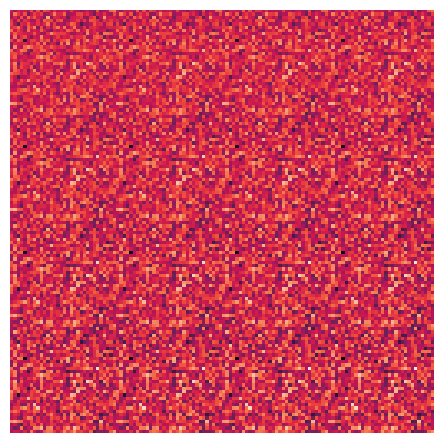

In [4]:
tt = [ii[0].permute([1, 2, 0]).numpy() for ii in rr]
plt.imshow(np.vstack([np.hstack(tt[row * 4: row * 4 + 4]) for row in range(4)]))
plt.axis("off")

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

epochs = 2

save_path = "checkpoints"
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)
eval_x0 = torch.randn([16, image_channels, image_size, image_size])

bar_format = "{n_fmt}/{total_fmt} [{bar:30}] - ETA: {elapsed}<{remaining} {rate_fmt}{postfix}{desc}"
for epoch_id in range(epochs):
    print("Epoch {}/{}".format(epoch_id, epochs))
    process_bar = tqdm(enumerate(data_loader), total=len(data_loader), bar_format=bar_format, ascii=".>>=")
    avg_loss = 0.0
    for batch, (xx, _) in process_bar:
        optimizer.zero_grad()
        loss = ddpm.loss(xx)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        process_bar.desc = " - loss: {:.4f}".format(avg_loss / (batch + 1))
        process_bar.refresh()
        if batch == 10:
            break
        
    torch.save(eps_model.state_dict(), os.path.join(save_path, "test_mnist.pt"))
    eval_xt = ddpm.generate(x0=eval_x0, return_inner=False).permute([0, 2, 3, 1]).numpy()
    eval_xt = eval_xt[:, :, :, 0] if eval_xt.shape[-1] == 1 else eval_xt
    eval_xt = np.vstack([np.hstack(eval_xt[row * 4: row * 4 + 4]) for row in range(4)])
    eval_xt = np.clip(eval_xt, 0, 1)
    plt.imsave(os.path.join(save_path, "epoch_{}.jpg".format(epoch_id)), eval_xt)

Epoch 0/2


10/3750 [..............................] - ETA: 00:07<45:55  1.36it/s - loss: 0.8838


Epoch 1/2


10/3750 [..............................] - ETA: 00:09<57:04  1.09it/s - loss: 0.7651
